<a href="https://colab.research.google.com/github/anshulsawant/Void-Seg/blob/main/DistanceSegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ssh-keyscan -t ed25519 github.com > ~/.ssh/known_hosts
!rm -rf /content/Void-Seg/
!git clone https://github.com/anshulsawant/Void-Seg.git
import tensorflow as tf

from google.colab import drive

import cv2

from glob import glob
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output
import matplotlib.pyplot as plt

from sklearn import metrics as skm
import random

from tensorflow.python.ops import math_ops

SIZE = 1024

import sys
if not '/content/Void-Seg/src' in sys.path:
  sys.path.append('/content/Void-Seg/src')
import importlib
importlib.invalidate_caches()
import images
import datasets
import utils
import metrics as M
import models
importlib.reload(images)
importlib.reload(datasets)
importlib.reload(utils)
importlib.reload(M)
importlib.reload(models)

/bin/bash: /root/.ssh/known_hosts: No such file or directory
Cloning into 'Void-Seg'...
remote: Enumerating objects: 5123, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 5123 (delta 186), reused 223 (delta 143), pack-reused 4834
Receiving objects: 100% (5123/5123), 297.14 MiB | 12.27 MiB/s, done.
Resolving deltas: 100% (2142/2142), done.
Updating files: 100% (5123/5123), done.


<module 'models' from '/content/Void-Seg/src/models.py'>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading images from /content/Void-Seg/dataset/train.
/content/Void-Seg
864
781
/content/Void-Seg/dataset/train/images/100kX_300kV_0651_3_3_rot180.png
(512, 512, 1)
(512, 512, 1)


<Figure size 1000x2000 with 0 Axes>

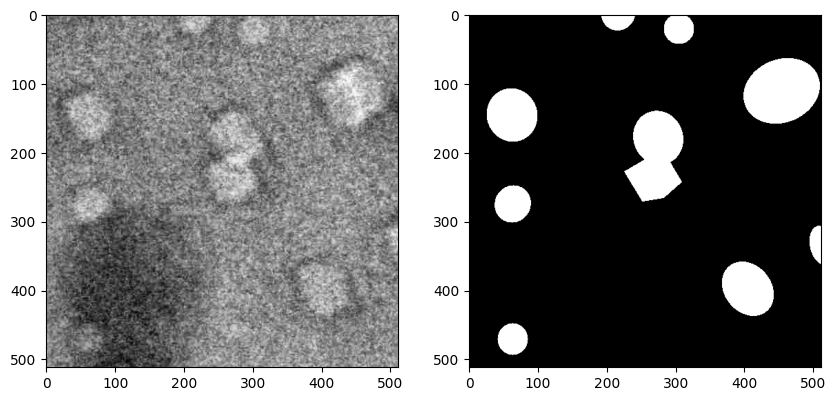

In [3]:
u, v, _, _ = images.load_image_paths()
print(images.ROOT)
print(len(u))
## Can you spot the problem in the masks below?
i = 781 ## random.randint(0, len(u))
print(i)
print(u[i])
x = images.load_image(u[i])
y = images.load_mask(v[i])
print(x.shape)
print(y.shape)

raw_image = cv2.imread(u[i])
raw_mask = cv2.imread(v[i], flags=cv2.IMREAD_GRAYSCALE)
plt.rcParams["figure.figsize"] = (10,20)
plt.figure()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(x[:,:,0], cmap = 'gray') 
axarr[1].imshow(y[:,:,0], cmap = 'gray')
plt.show()

**Image Augmentation Methods**

In [3]:

    # Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = models.distance_model(SIZE//2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512)]   0           []                               
                                                                                                  
 reshape (Reshape)              (None, 512, 512, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 4)  104         ['reshape[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 512, 512, 5)  0           ['reshape[0][0]',                
                                                                  'conv2d[0][0]']             

In [4]:
def distance_loss(y_true, y_pred):
    s = tf.cast(y_true.shape[1]/2, tf.int32)
    y_true_mask = y_true[:,0:s]
    y_true_dist = y_true[:,s:2*s] + 1
    bce = K.binary_crossentropy(y_true_mask, y_pred[:,0:s])
    return K.mean(y_true_dist*bce)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

def schedule(epoch, lr):
  return lr*np.exp(-0.1)

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Segmentation/segmentation_distance_50", save_best_only=True),
    keras.callbacks.LearningRateScheduler(schedule)
]
# Train the model, doing validation at the end of each epoch.
epochs = 50
training_data, validation_data = datasets.create_distance_dataset(batch=32)
keras.backend.clear_session()

restore = True
retrain = False
if restore:
  model = tf.keras.models.load_model('/content/drive/MyDrive/Segmentation/segmentation_distance_50', custom_objects = {'distance_loss':distance_loss})
  if retrain:
    keras.backend.set_value(model.optimizer.learning_rate, 0.0001)
    model.fit(training_data, validation_data=validation_data, epochs=epochs, callbacks = callbacks)
else:
  model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=distance_loss)
  model.fit(training_data, validation_data=validation_data, epochs=epochs, callbacks = callbacks)

Loading images from /content/Void-Seg/dataset/train.
Creating dataset with 864 images.
Using 691 images for training.


In [6]:
ds = datasets.create_distance_test_dataset(batch=31)

eval = model.evaluate(x = ds, return_dict=True)
print(eval)

Loading images from /content/Void-Seg/dataset/test.
Loading 28 images for testing.


NameError: ignored

Loading images from /content/Void-Seg/dataset/test.
Loading 28 images for testing.
1/1 [==============================] - 0s 35ms/step


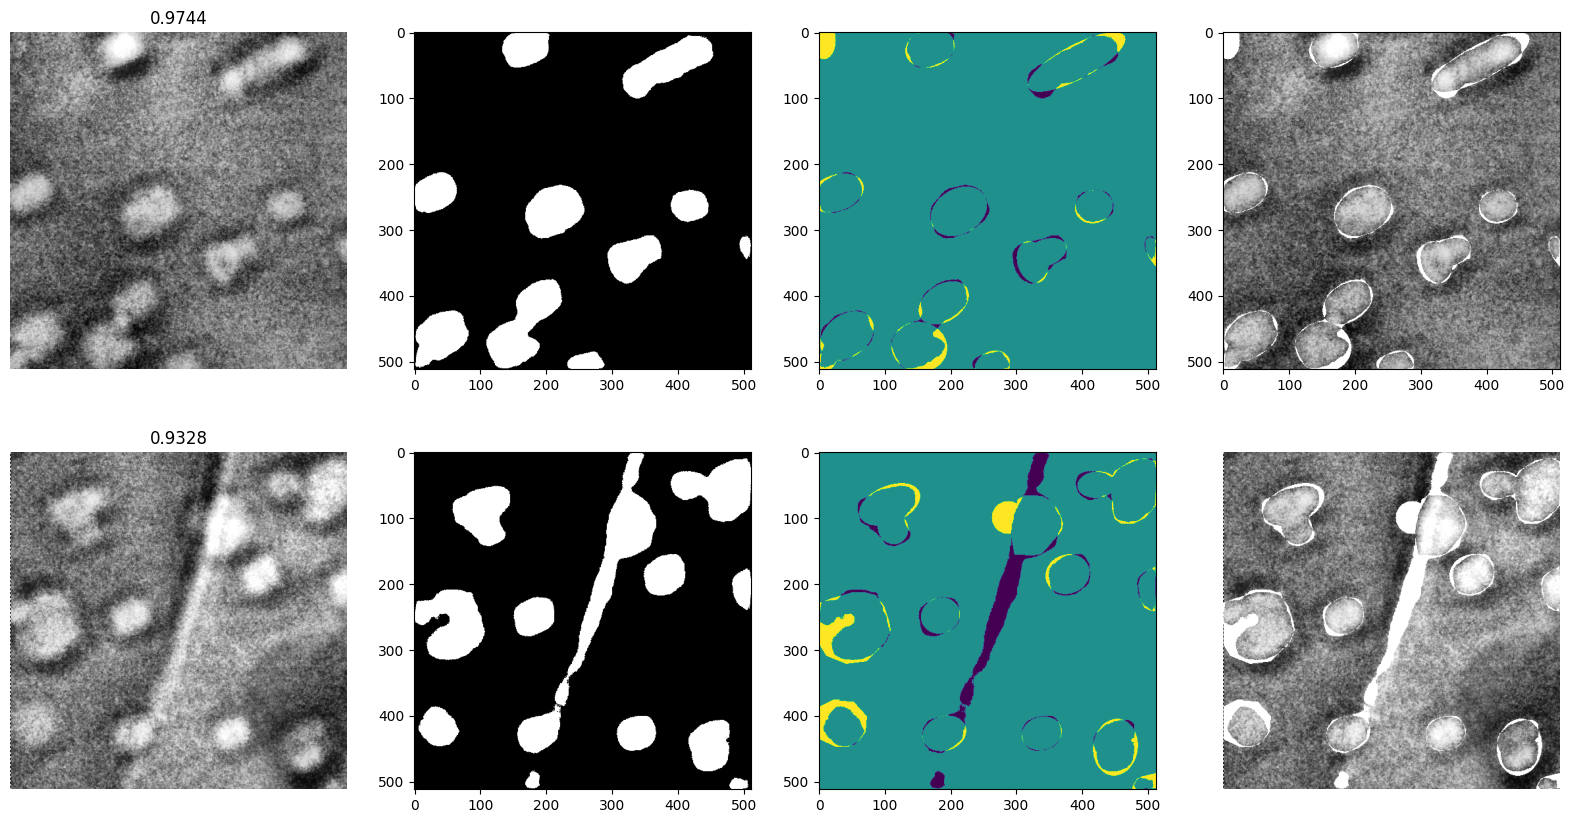

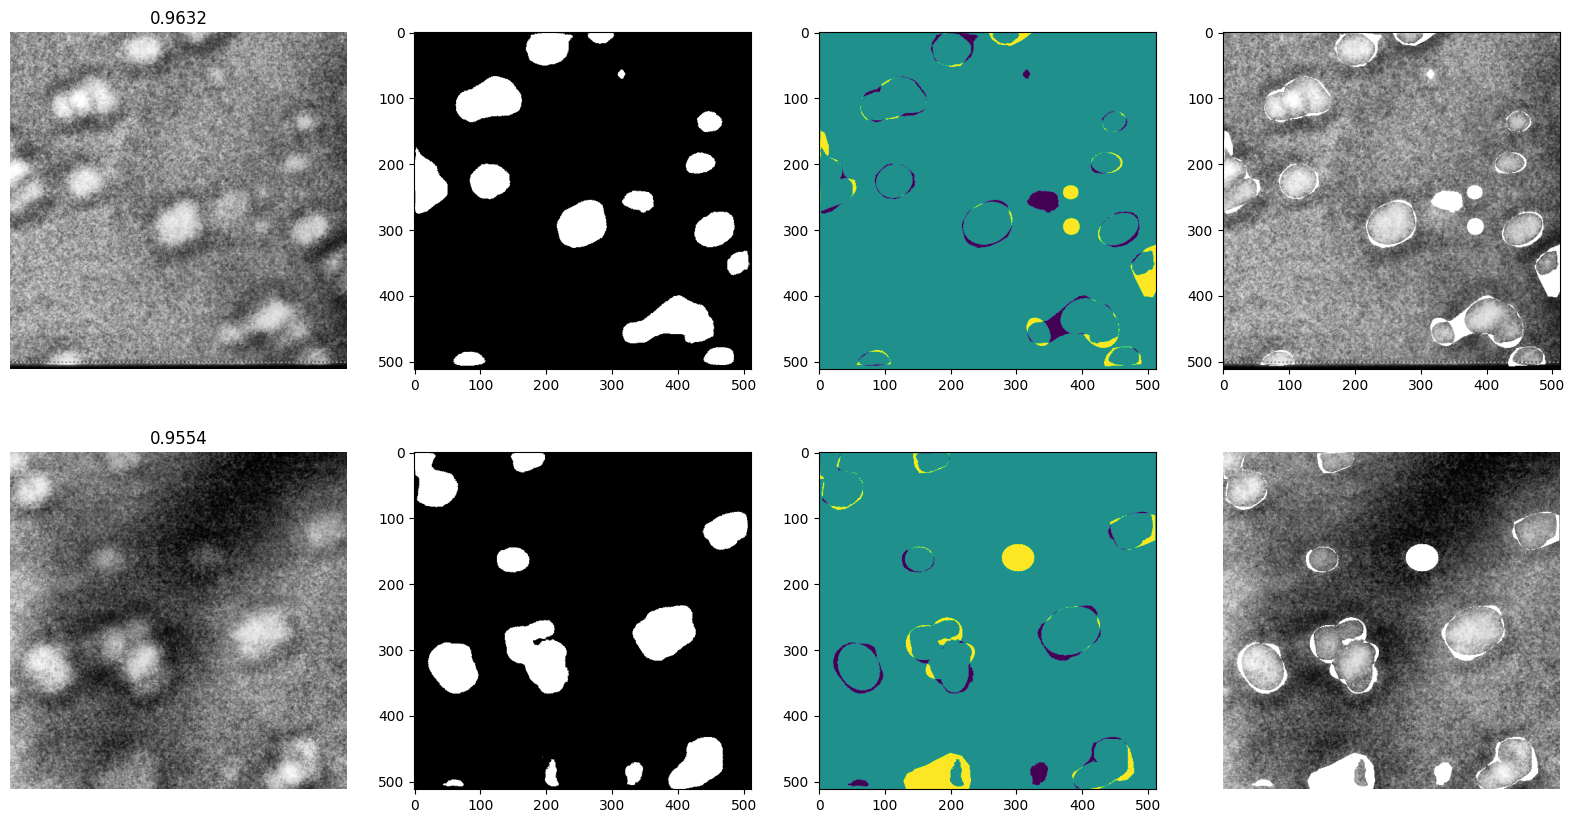

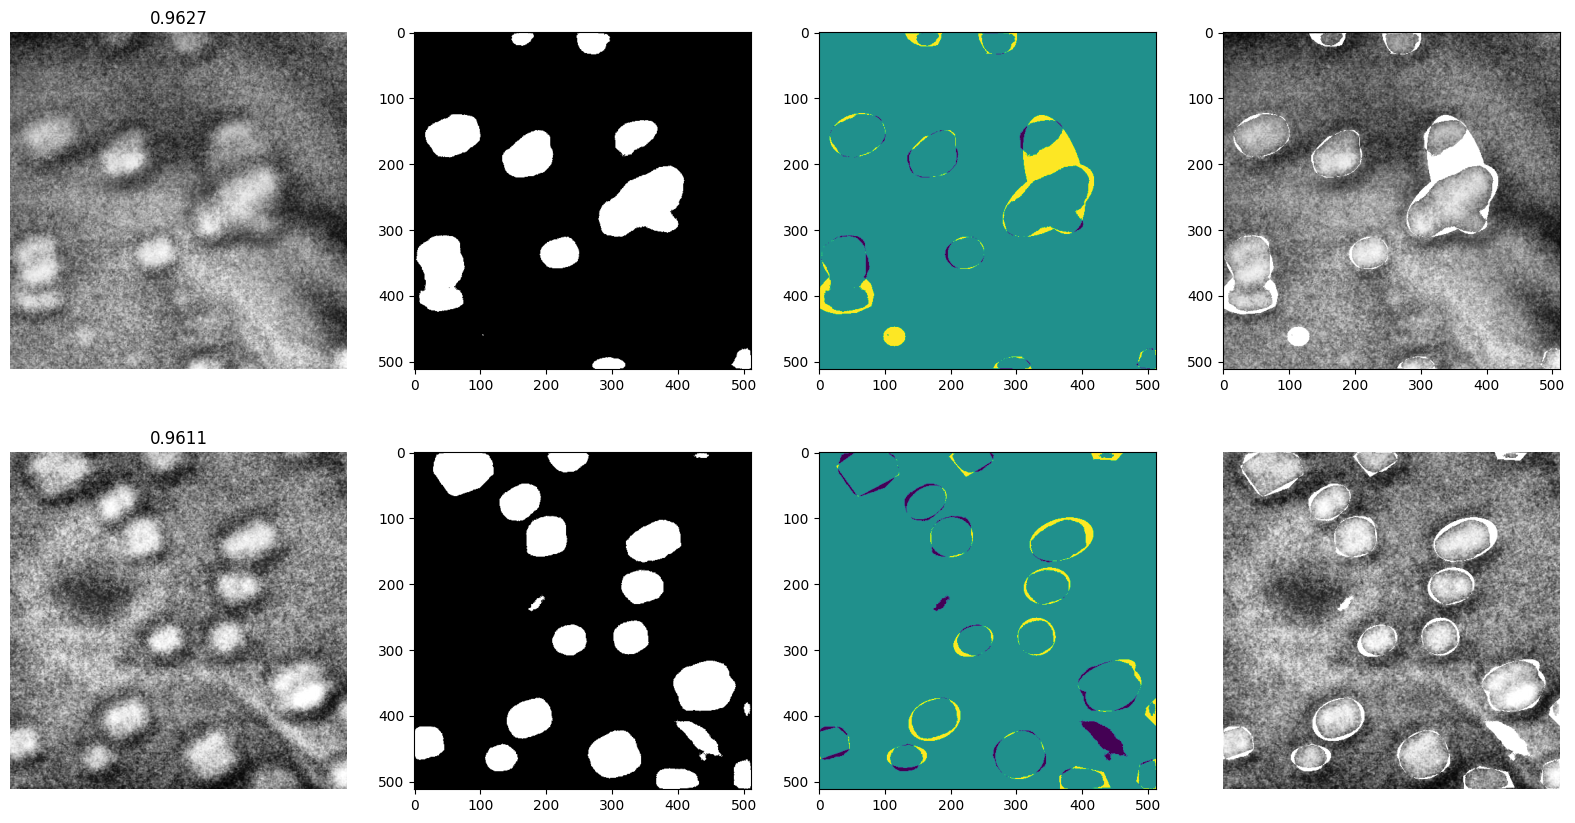

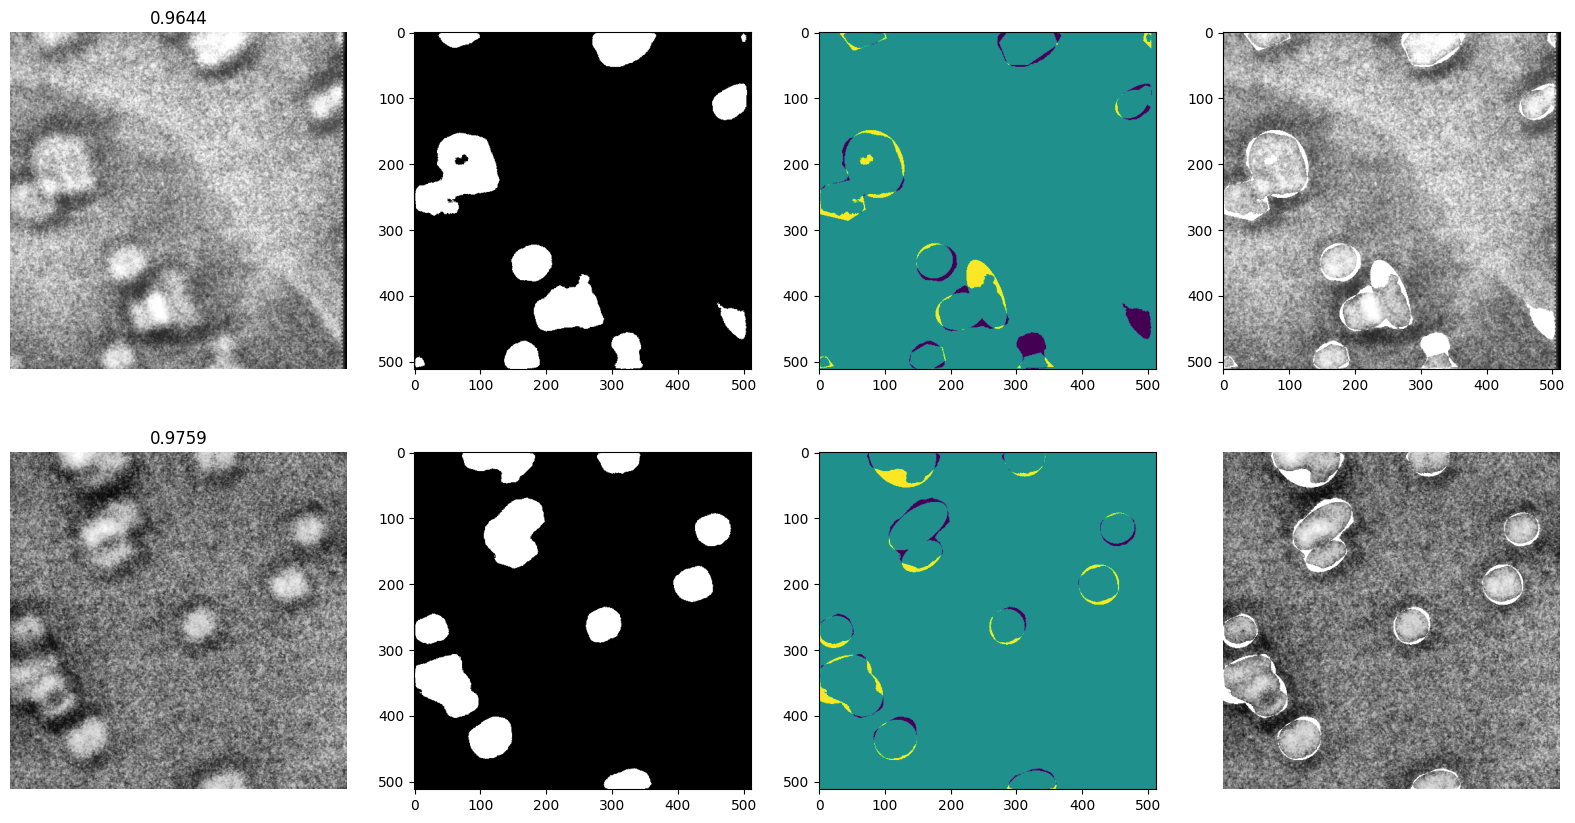

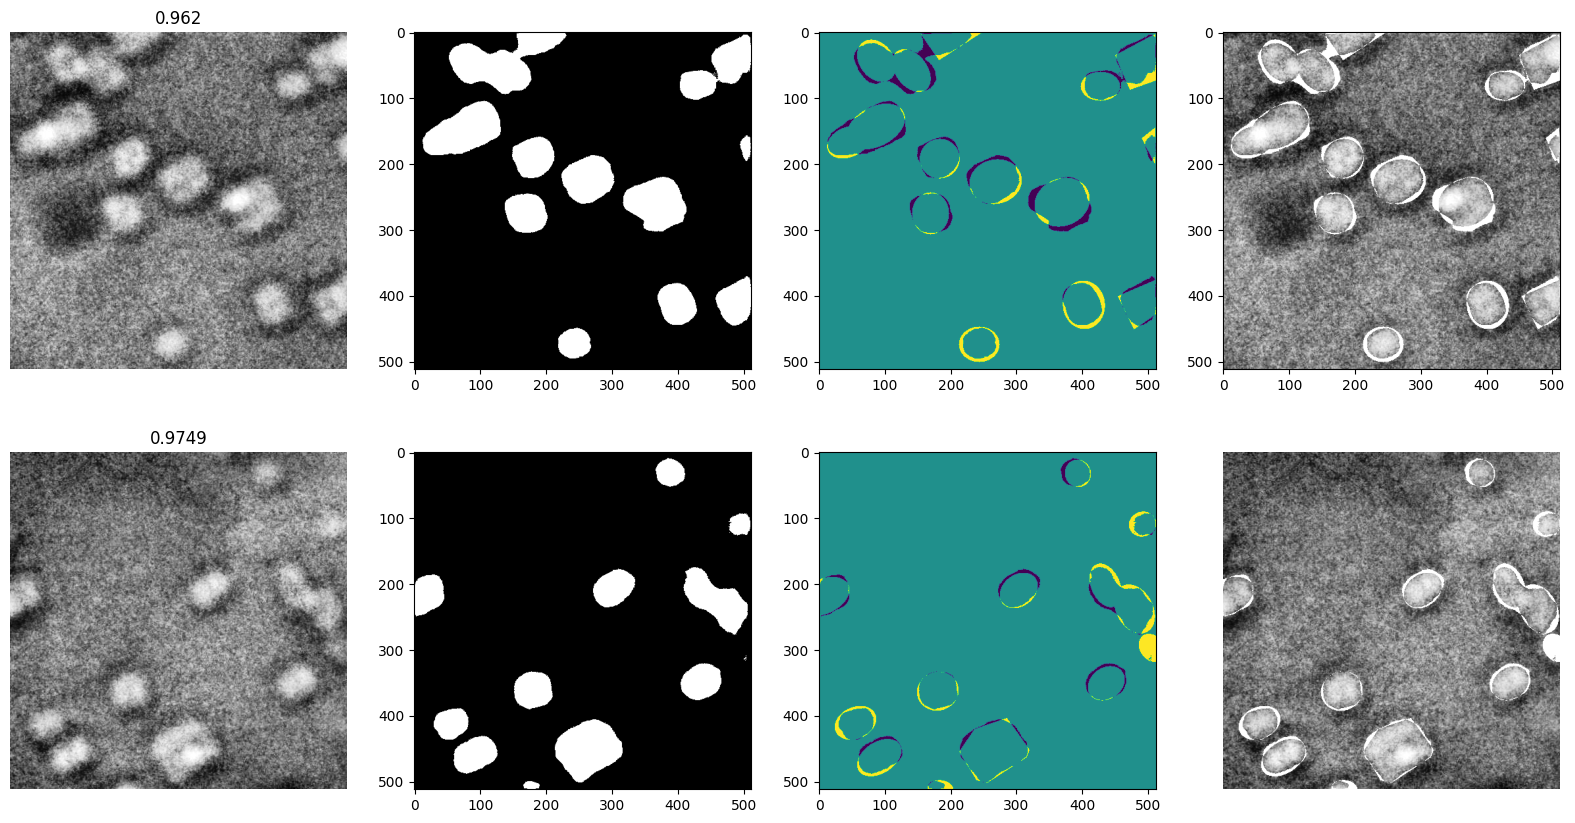

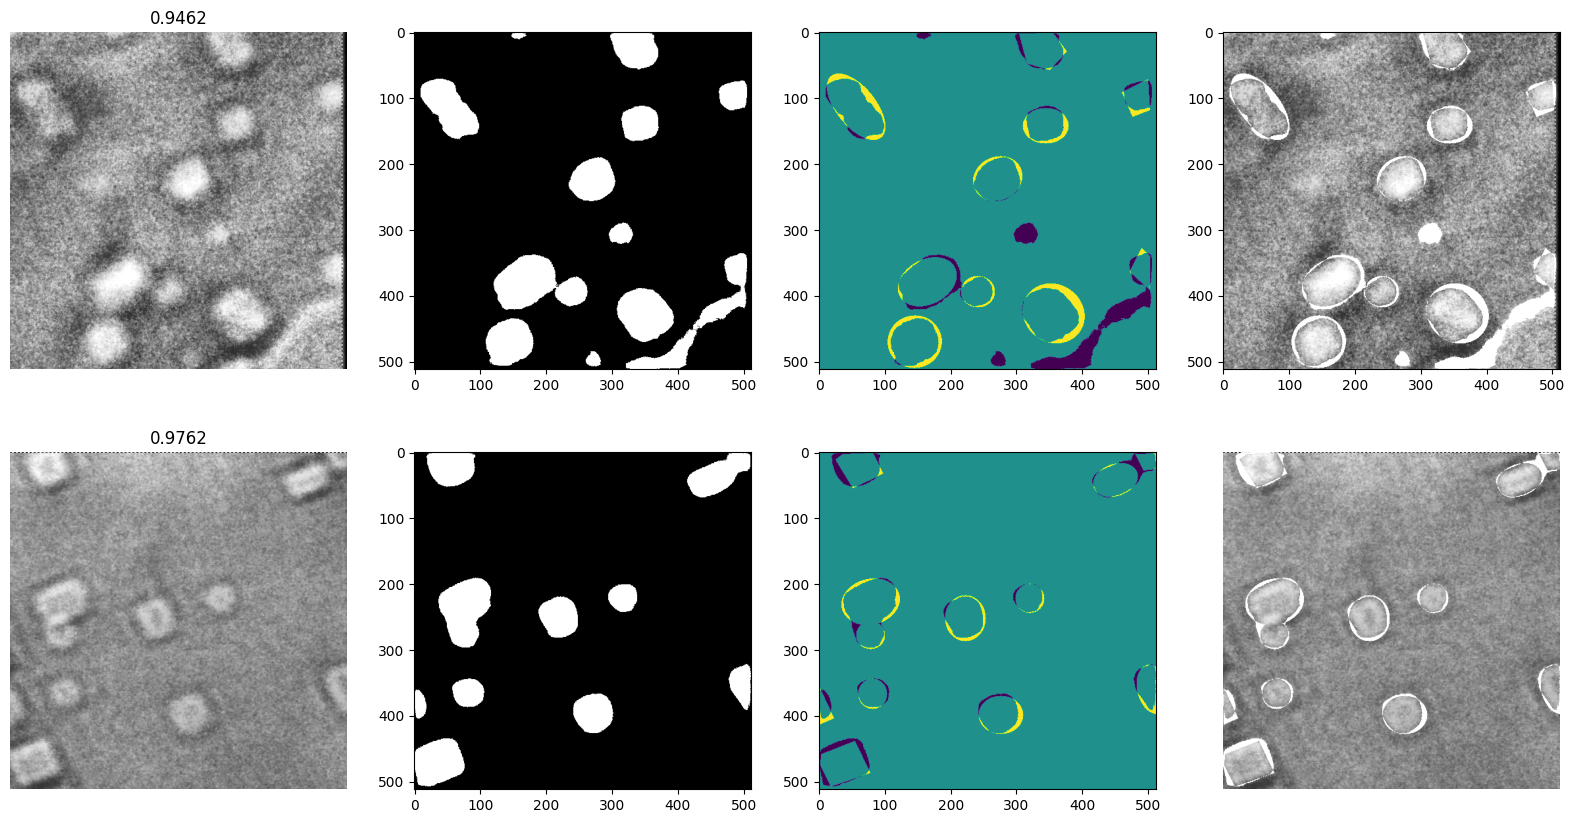

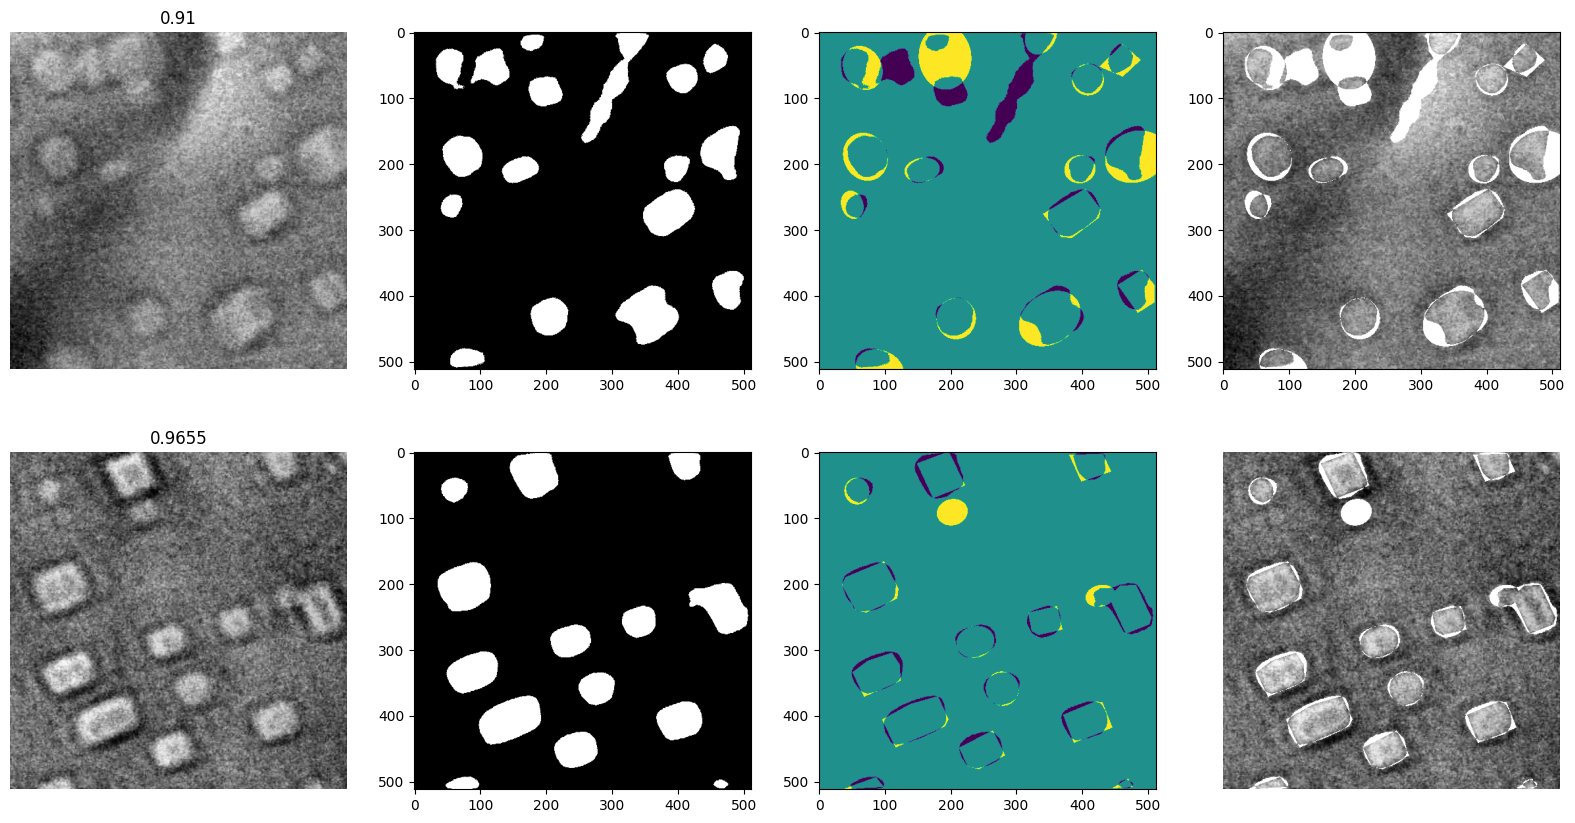

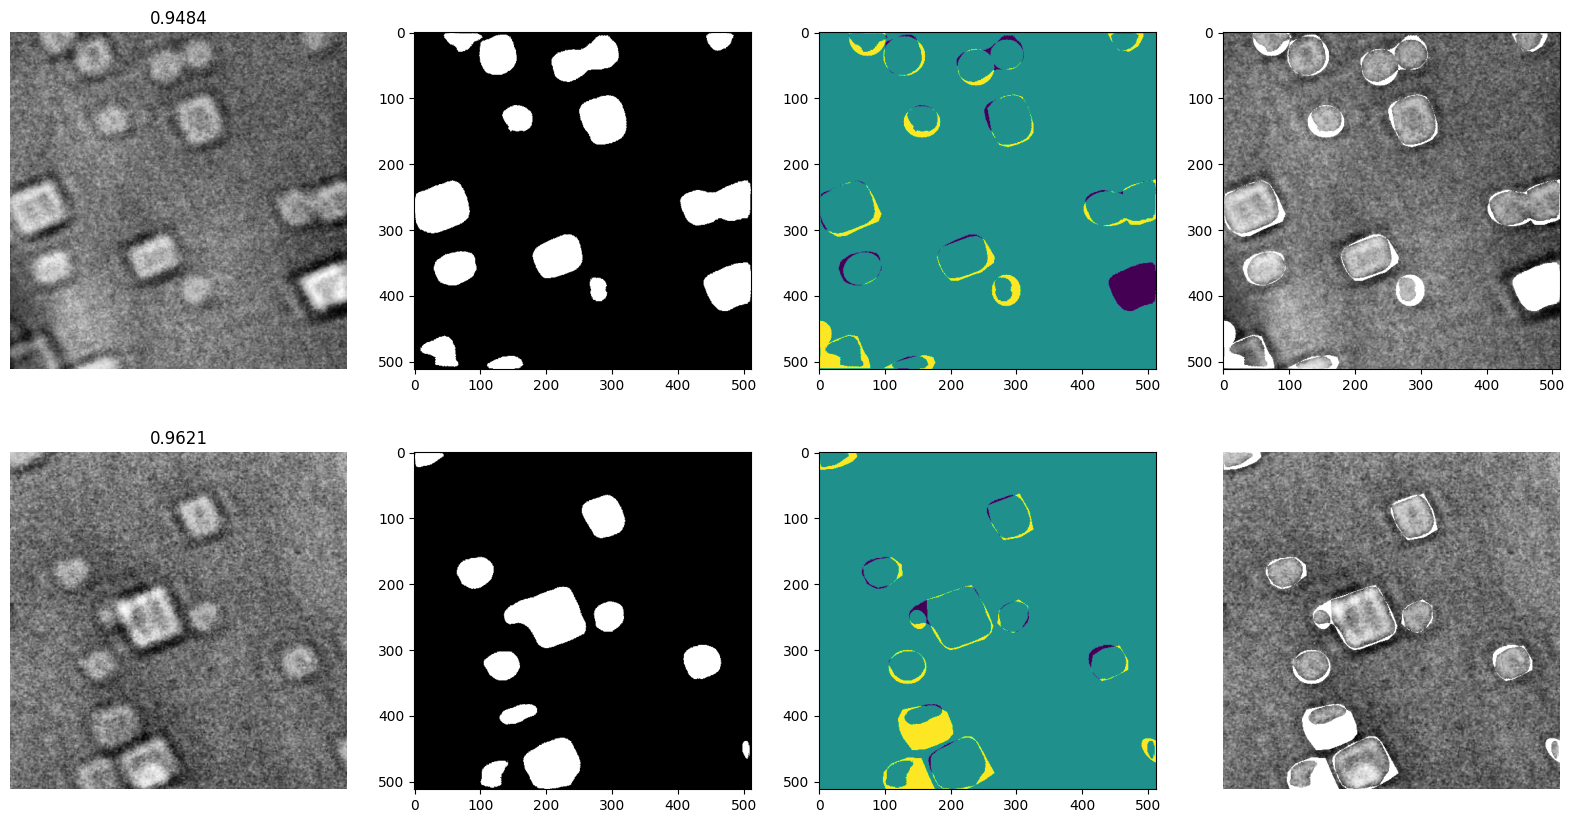

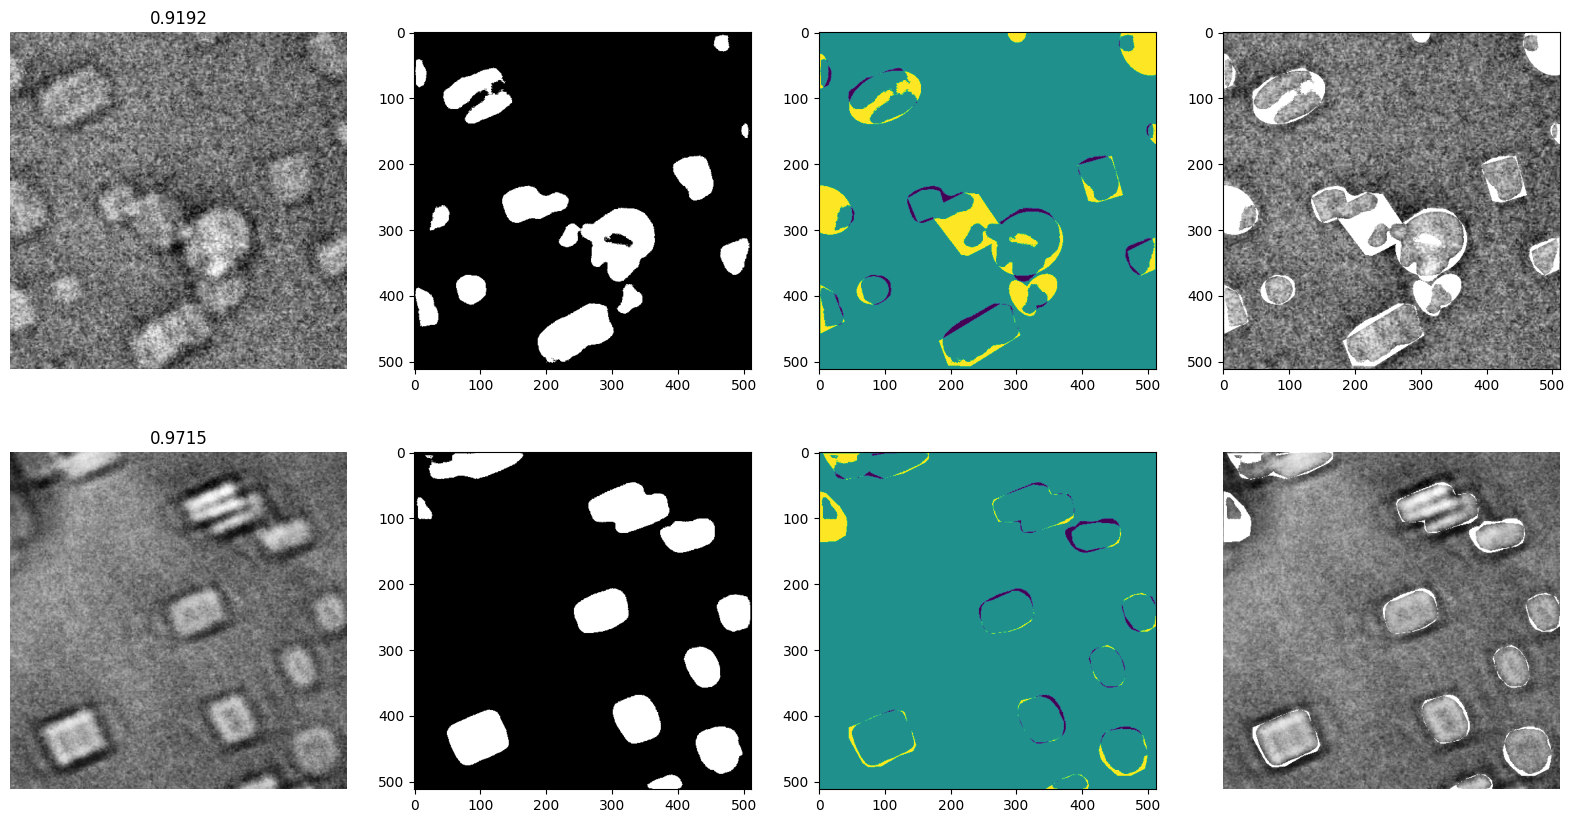

In [7]:
ds = datasets.create_distance_test_dataset(batch=2)

def top(x):
  s = tf.cast(x.shape[0]/2, tf.int32)
  return x[0:s]
def top_np(x):
  s = int(x.shape[0]/2)
  return x[0:s]

def top_all(x):
  s = tf.cast(x.shape[1]/2, tf.int32)
  return x[:,0:s]

def accuracy_ordering(images, masks, predictions):
  acc = [None]*images.shape[0]
  for i in range(images.shape[0]):
    prediction = top(predictions[i])
    prediction = prediction.reshape((512, 512))
    image = images[i].reshape((512, 512))
    mask = top(masks[i])
    mask = mask.reshape((512, 512))      
    p = (prediction >= 0.5)*1 
    mislabels = np.abs(mask - p)
    n = np.sum(mislabels == 1.)
    acc[i] = 1 - n/(512. * 512.)
  if True:
    return list(range(images.shape[0]))
  return np.array(acc).argsort()

def plot_predictions(images, masks, predictions):
  images = images.numpy()
  masks = masks.numpy()
  acc_order = accuracy_ordering(images, masks, predictions)
  images = images[acc_order]
  masks = masks[acc_order]
  predictions = predictions[acc_order]
  N = images.shape[0]
  n_cols = 4
  n_rows = N
  plt.rcParams["figure.figsize"] = (5*n_cols, 5*n_rows)
  f, a = plt.subplots(n_rows, n_cols)
  plt.axis('off')
  for i in range(N):
    plot_prediction(images[i], masks[i], top_np(predictions[i]), a[i])

def plot_prediction(image, mask, prediction, ax):
  prediction = prediction.reshape((512, 512))
  image = image.reshape((512, 512))
  mask = top(mask).reshape((512, 512))
  p = (prediction >= 0.5)*1
  ax[0].axis('off')
  ax[0].imshow(image, cmap='gray')
  ax[1].imshow(p, cmap='gray')
  ax[2].imshow(mask-p)
  white = np.ones((512, 512))
  mislabels = np.abs(mask - p)
  ax[3].imshow(image, cmap='gray', alpha=( 1 - mislabels))
  n = np.sum(mislabels == 1.)
  acc = 1 - n/(512. * 512.)
  ax[0].title.set_text(str(np.round(acc, 4)))

for (x, y) in ds:
  yy = model.predict(x)
  plot_predictions(x, y, yy)


In [5]:

def top_all(x):
  s = tf.cast(x.shape[1]/2, tf.int32)
  return x[:,0:s]

ds = datasets.create_distance_test_dataset(batch = 29)
images = None
masks = None
for image, mask in ds:
  images = image
  masks = top_all(mask)

masks_pred = top_all(model.predict(images))
print(masks_pred.shape)

Loading images from /content/Void-Seg/dataset/test.
Loading 28 images for testing.
1/1 [==============================] - 21s 21s/step
(28, 262144)


In [9]:
import pandas as pd
x = M.all_feature_metrics(masks, masks_pred, thresholds = [0.5, 0.6, 0.7, 0.8, 0.9])
pd.DataFrame(x, columns = ['Precision', 'Recall', 'IOU', 'Accuracy', 'Threshold'])

Precision    Recall       IOU  Accuracy  Threshold
0   0.847769  0.809524  0.735763  0.706783        0.5
1   0.784777  0.749373  0.645788  0.621622        0.6
2   0.727034  0.694236  0.571134  0.550696        0.7
3   0.551181  0.526316  0.380435  0.368421        0.8
4   0.115486  0.110276  0.061281  0.059783        0.9

In [6]:
import pandas as pd
x = M.all_pixel_metrics(masks, masks_pred, np.arange(0.01, 0.98, 0.01))
y = pd.DataFrame(x, columns = ['Precision', 'Recall', 'IOU', 'Accuracy', 'Mean Absolute Area Error', 'Mean Area Error', 'Precision SD', 'Recall SD', 'IOU SD', 'Acc SD', 'MAAE SD', 'MAE SD', 'Threshold',])
y[y['Threshold'] == 0.5]

/content/Void-Seg/src/metrics.py:95: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp + fp)


Precision    Recall       IOU  Accuracy  Mean Absolute Area Error  \
49      0.881  0.850204  0.762581  0.956393                  0.071805   

    Mean Area Error  Precision SD  Recall SD    IOU SD    Acc SD   MAAE SD  \
49         0.032441      0.051003   0.075503  0.075863  0.018311  0.070181   

      MAE SD  Threshold  
49  0.095021        0.5

In [11]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))

def open(masks):
  def f(mask):
    x = mask.reshape((512, 512))
    return cv2.morphologyEx(x, cv2.MORPH_OPEN, kernel).reshape((-1))
  return np.apply_along_axis(f, 1, masks)

opened = open(masks_pred)
import pandas as pd
x = M.all_feature_metrics(masks, opened, thresholds = [0.5, 0.6, 0.7, 0.8, 0.9])
print(pd.DataFrame(x, columns = ['Precision', 'Recall', 'IOU', 'Accuracy', 'Threshold']))
x = M.all_pixel_metrics(masks, opened, np.arange(0.01, 0.98, 0.01))
y = pd.DataFrame(x, columns = ['Precision', 'Recall', 'IOU', 'Accuracy', 'Mean Absolute Area Error', 'Mean Area Error', 'Threshold'])
y[y['Threshold'] == 0.5]

   Precision    Recall       IOU  Accuracy  Threshold
0   0.855643  0.799020  0.747706  0.704104        0.5
1   0.797900  0.745098  0.663755  0.626804        0.6
2   0.740157  0.691176  0.587500  0.556213        0.7
3   0.553806  0.517157  0.382940  0.365052        0.8
4   0.115486  0.107843  0.061281  0.059060        0.9


/content/Void-Seg/src/metrics.py:89: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp + fp)


Precision   Recall       IOU  Accuracy  Mean Absolute Area Error  \
49   0.882664  0.84819  0.762207  0.956418                  0.071803   

    Mean Area Error  Threshold  
49         0.036624        0.5